**Notebook containing code looking at similarities between gene expression data and corresponding ATAC gene scores**

In [15]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
data_dir = Path("../Data/SCDRS/multiome")
gene_score_file = data_dir / "ATAC_gene_scores_pp.h5ad"
gene_exp_file = data_dir / "ATAC_gene_expression_pp.h5ad"

In [3]:
# Read gene scores
gs = sc.read_h5ad(gene_score_file)

In [4]:
# Read gene expression
expr = sc.read_h5ad(gene_exp_file)

In [18]:
genes = list(set(expr.var_names).intersection(gs.var_names))

expr_df = pd.DataFrame(
    expr[:, genes].X.toarray(), 
    index=expr.obs_names,
    columns=genes
)

atac_df = pd.DataFrame(
    gs[:, genes].X.toarray(),
    index=gs.obs_names,
    columns=genes
)

In [8]:
def compute_df_sparsity(df):
    total_elements = df.size
    nonzero_elements = (df != 0).sum().sum()
    sparsity = 1 - (nonzero_elements / total_elements)
    return sparsity

sparsity_expr = compute_df_sparsity(expr_df)
sparsity_atac = compute_df_sparsity(atac_df)

print(f"Sparsity of expr_df: {sparsity_expr:.4f}")
print(f"Sparsity of atac_df: {sparsity_atac:.4f}")

Sparsity of expr_df: 0.9197
Sparsity of atac_df: 0.5887


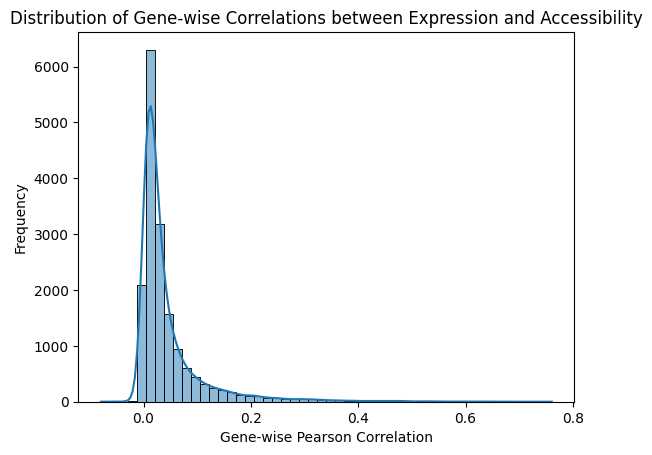

In [27]:
# Make sure cells are alligned
expr_df = expr_df.loc[atac_df.index]
atac_df = atac_df.loc[expr_df.index]

# Correlation across cells for each gene
gene_correlations = expr_df.corrwith(atac_df, axis=0, method='pearson')

# Visualize the distribution
sns.histplot(gene_correlations, bins=50, kde=True)
plt.xlabel("Gene-wise Pearson Correlation")
plt.ylabel("Frequency")
plt.title("Distribution of Gene-wise Correlations between Expression and Accessibility")
plt.show()

In [19]:
def plot_genewise_spearman_by_celltype(expr_df, atac_df, celltypes, title="Gene-wise Spearman Correlation by Cell Type"):
     shared_genes = expr_df.columns.intersection(atac_df.columns)
    records = []

    for celltype in celltypes.unique():
        cells = celltypes[celltypes == celltype].index

        expr_sub = expr_df.loc[cells, shared_genes]
        atac_sub = atac_df.loc[cells, shared_genes]

        for gene in shared_genes:
            x = expr_sub[gene]
            y = atac_sub[gene]

            if x.nunique() < 3 or y.nunique() < 3:
                continue

            r, _ = spearmanr(x, y)
            if not np.isnan(r):
                records.append({
                    "gene": gene,
                    "celltype": celltype,
                    "correlation": r
                })

    corr_df = pd.DataFrame(records)

    plt.figure(figsize=(12, 6))
    sns.violinplot(data=corr_df, x="celltype", y="correlation", inner="box", cut=0)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Cell Type")
    plt.ylabel("Spearman Correlation (Expression vs. Gene Score)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return corr_df

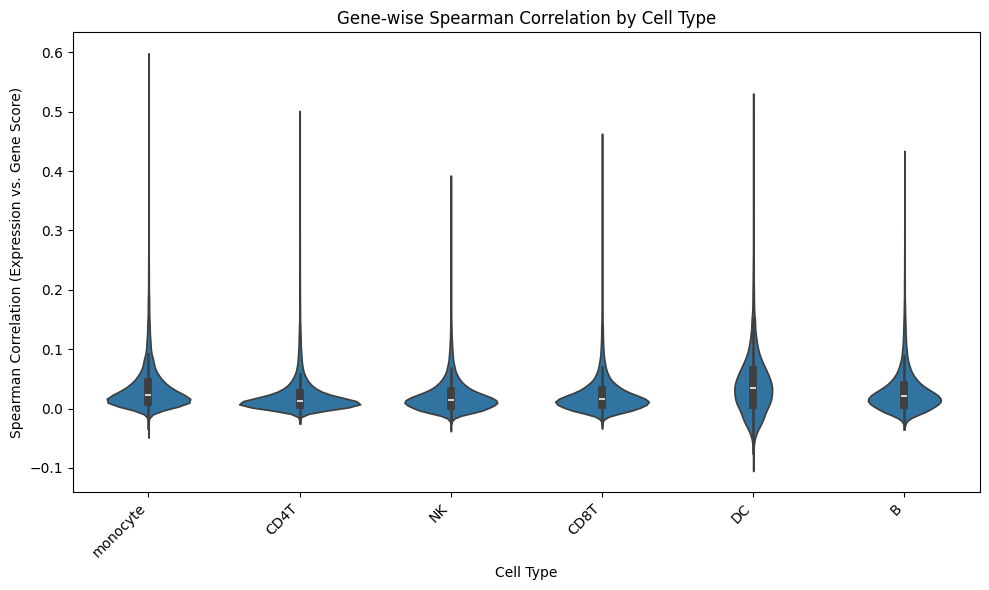

In [28]:
# Get cell type annotation
celltypes = expr.obs["celltype_imputed_lowerres"]

# Call the function
corr_df = plot_genewise_spearman_by_celltype(
    expr_df=expr_df,
    atac_df=atac_df,
    celltypes=celltypes,
    title="Gene-wise Spearman Correlation by Cell Type"
)

In [17]:
sc.pp.highly_variable_genes(expr, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=False)

hvg_genes = expr.var[expr.var['highly_variable']].index
hvg_genes = list(set(hvg_genes).intersection(gs.var_names))

hvg_expr_df = pd.DataFrame(
    expr[:, hvg_genes].X.toarray(),
    index=expr.obs_names,
    columns=genes
)

hvg_atac_df = pd.DataFrame(
    gs[:, hvg_genes].X.toarray(),
    index=gs.obs_names,
    columns=genes
)

celltypes = expr.obs["celltype_imputed_lowerres"]

In [13]:
print(atac_df.shape)
print(expr_df.shape)

(103483, 2298)
(103483, 2298)


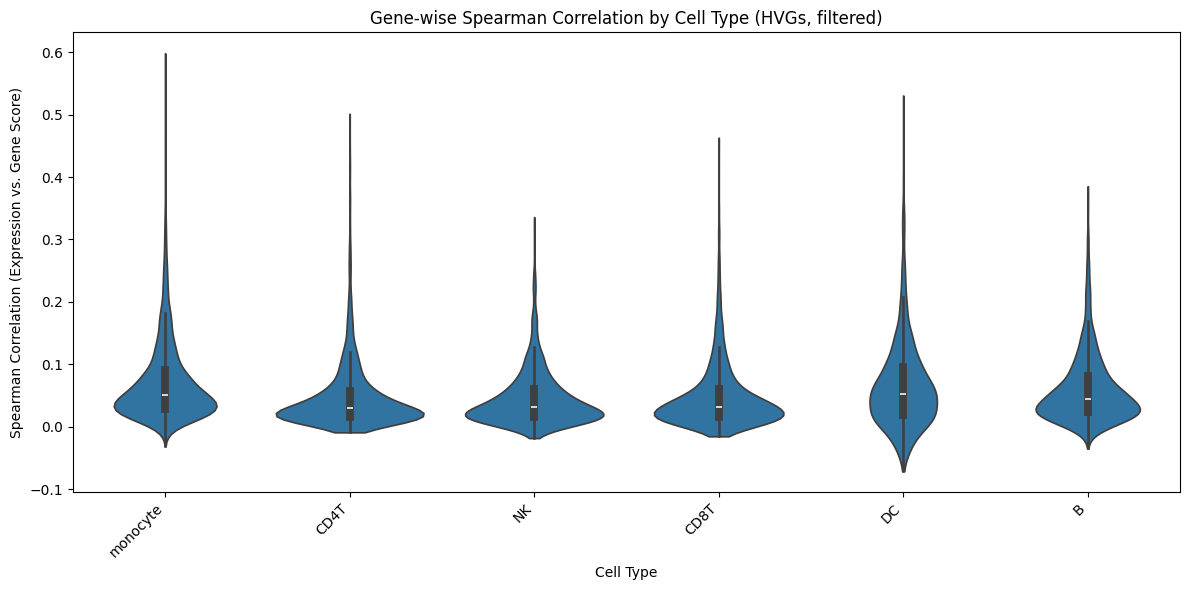

In [16]:
celltypes = expr.obs["celltype_imputed_lowerres"]

corr_df = plot_genewise_spearman_by_celltype(
    expr_df=hvg_expr_df,
    atac_df=hvg_atac_df,
    celltypes=celltypes,
    title="Gene-wise Spearman Correlation by Cell Type (HVGs, filtered)"
)

In [23]:
celltype_markers = {
    "Mono": ["CTSS", "FCN1", "NEAT1", "LYZ", "PSAP", "S100A9", "AIF1", "MNDA", "SERPINA1", "TYROBP"],
    "CD4 T": ["IL7R", "MAL", "LTB", "CD4", "LDHB", "TPT1", "TMSB10", "CD3D", "CD3G"],
    "CD8 T": ["CD8B", "CD8A", "CD3D", "TMSB10", "HCST", "CD3G", "CTSW", "CD3E"],
    "NK": ["NKG7", "KLRD1", "TYROBP", "GNLY", "FCER1G", "PRF1", "CD247", "KLRF1", "CST7", "GZMB"],
    "B": ["CD79A", "RALGPS2", "CD79B", "MS4A1", "BANK1", "CD74", "TNFRSF13C", "HLA-DQA1", "MEF2C"],
    "DC": ["CD74", "HLA-DPA1", "HLA-DPB1", "HLA-DQA1", "CCDC88A", "HLA-DRA", "HLA-DMA", "CST3", "HLA-DQB1", "HLA-DRB1"]
}

In [24]:
marker_genes_all = set(gene for gene_list in celltype_markers.values() for gene in gene_list)

common_genes = set(expr.var_names).intersection(gs.var_names)
genes = list(marker_genes_all.intersection(common_genes))

marker_expr_df = pd.DataFrame(
    expr[:, genes].X.toarray(), 
    index=expr.obs_names,
    columns=genes
)

marker_atac_df = pd.DataFrame(
    gs[:, genes].X.toarray(),
    index=gs.obs_names,
    columns=genes
)

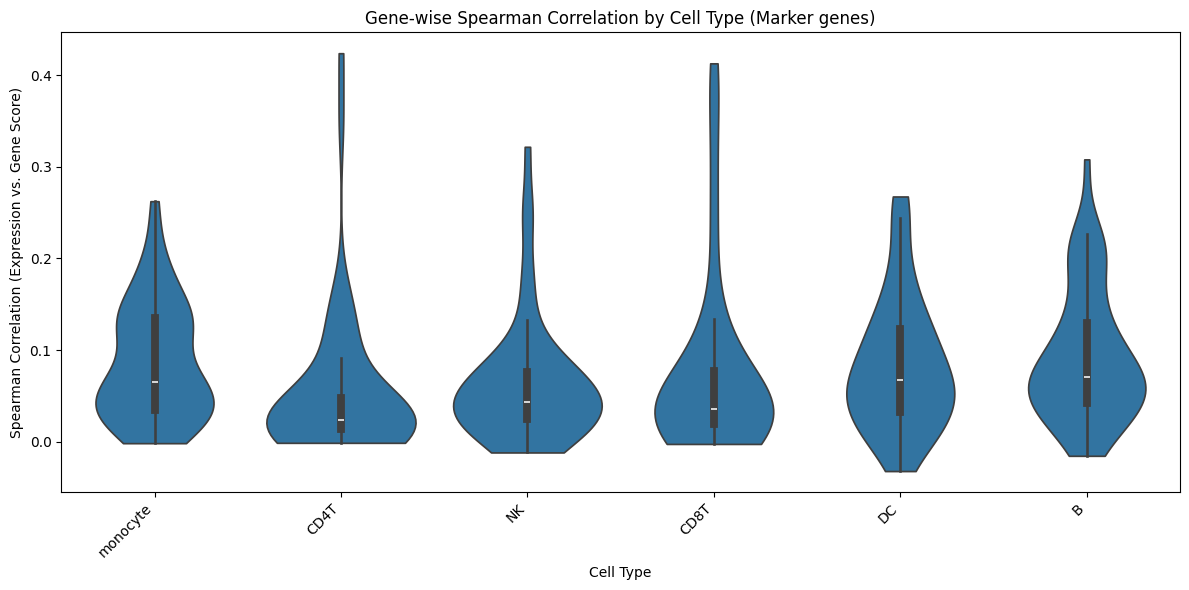

In [25]:
corr_df = plot_genewise_spearman_by_celltype(
    expr_df=marker_expr_df,
    atac_df=marker_atac_df,
    celltypes=celltypes,
    title="Gene-wise Spearman Correlation by Cell Type (Marker genes)"
)

Gene expression marker genes:


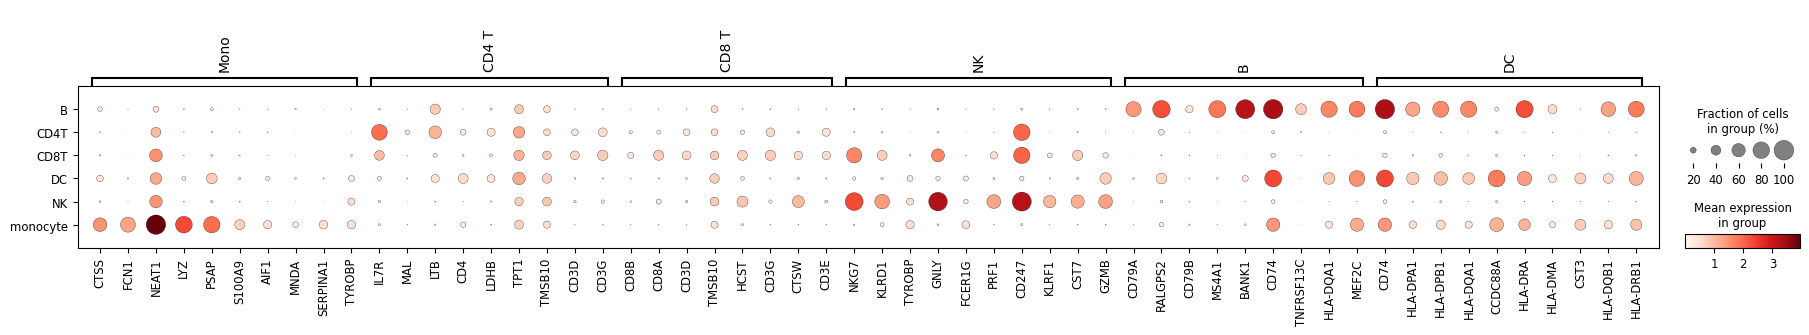

Gene score marker genes:


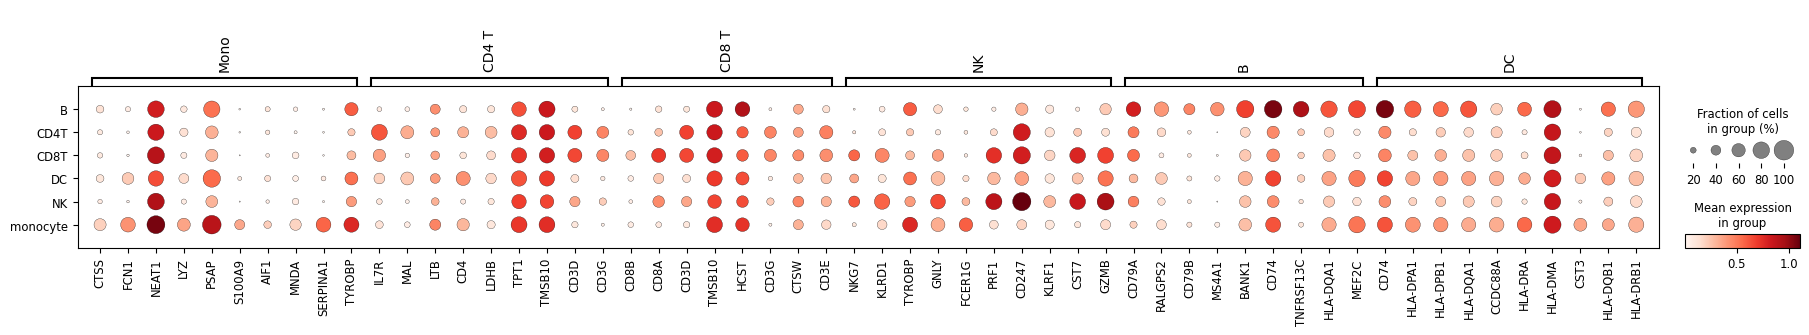

In [26]:
print("Gene expression marker genes:")
sc.pl.dotplot(expr, var_names=celltype_markers, groupby='celltype_imputed_lowerres')
print("Gene score marker genes:")
sc.pl.dotplot(gs, var_names=celltype_markers, groupby='celltype_imputed_lowerres')

In [52]:
# Scale values to 0 mean and unit variance
expr_scaled = expr.copy()
sc.pp.scale(expr_scaled)  
expr.layers["scaled"] = expr_scaled.X


gs_scaled = gs.copy()
sc.pp.scale(gs_scaled)
gs.layers["scaled"] = gs_scaled.X

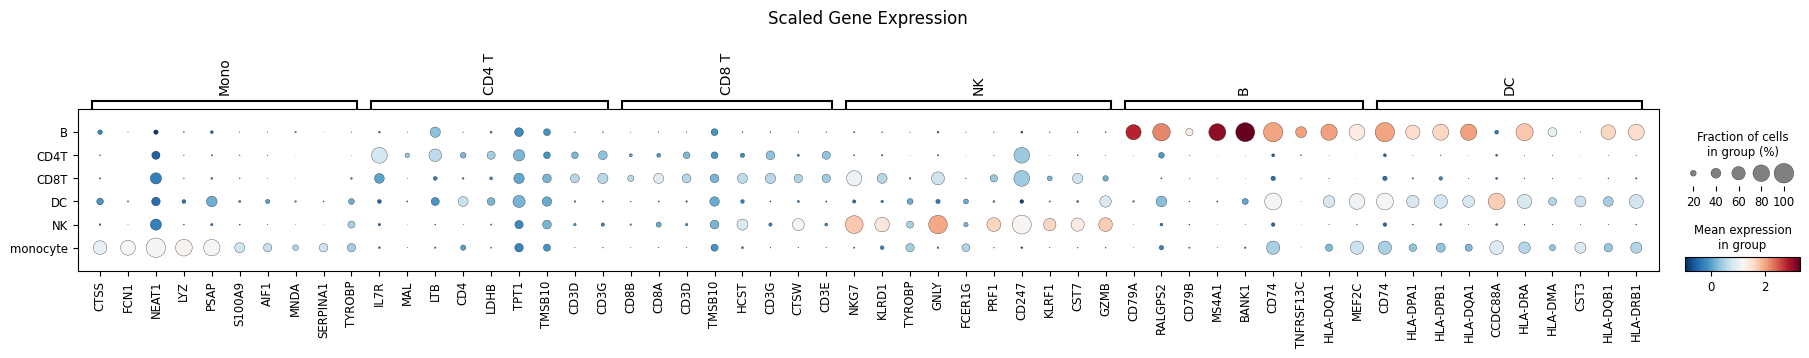

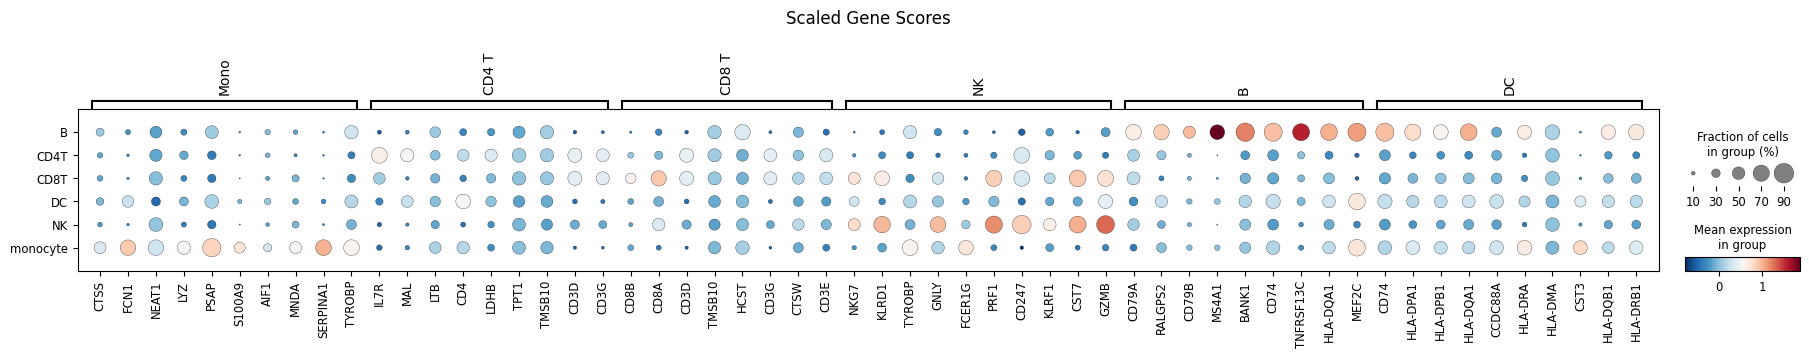

In [54]:
sc.pl.dotplot(
    expr,
    var_names=celltype_markers,
    groupby='celltype_imputed_lowerres',
    layer='scaled',
    standard_scale=None,
    color_map='RdBu_r',
    title='Scaled Gene Expression'
)

# Gene score dotplot
sc.pl.dotplot(
    gs,
    var_names=celltype_markers,
    groupby='celltype_imputed_lowerres',
    layer='scaled',
    standard_scale=None,
    color_map='RdBu_r',
    title='Scaled Gene Scores'
)